In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


## Figure 1

In [31]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
coeffs = loadmat('./Results/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]

params = dmf.default_params(C=C)
params['seed'] = 1
params['G'] = 2.1
params['obj_rate'] = 3.44
LR = 10
DECAY = np.exp(a+np.log(LR)*b)
params['taoj'] = DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]
with_decay = True
with_plasticity = True
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True, with_plasticity=with_plasticity, with_decay=with_decay)
brunout = 5

dyn_fic = np.mean(fic_t, axis=1)
stat_fic = params['J']

Calling run
(4005, 119)
(150, 90)
(31, 90)


Text(0.5, 1.0, 'Per region FIC comparison G=2.11 LR=10')

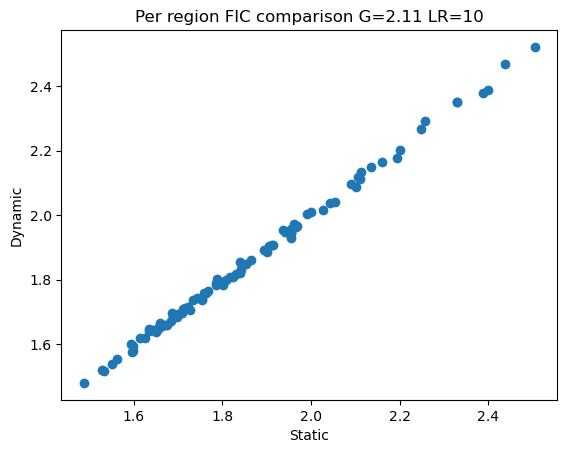

In [35]:
fig1a, axa1 = plt.subplots()
plt.scatter(stat_fic,dyn_fic,marker='o')
plt.xlabel("Static")
plt.ylabel("Dynamic")
plt.title("Per region FIC comparison G=2.11 LR=10")

## Figure 1.b


In [ ]:
nb_steps = 10000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
coeffs = loadmat('./Results/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
brunout = 5
params = dmf.default_params(C=C)
params['seed'] = 1
params['G'] = 2.1
params['obj_rate'] = 3.44
LR = 10
DECAY = np.exp(a+np.log(LR)*b)
params['taoj'] = DECAY
params['lrj'] = LR

N = C.shape[0]
with_decay = True
with_plasticity = True
G_range = np.arange(0,16,0.25)
all_rates = np.zeros((2,len(G_range), 90))
for idx_G in range(len(G_range)):
    params['G'] = G_range[idx_G]
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    rates_dyn, r_ing,a,d = dmf.run(params, nb_steps,return_rate=True, return_bold=False, return_fic=False, with_plasticity=True, with_decay=True)
    rates_dyn = rates_dyn[:, np.ceil(brunout * 1000).astype(int):]
    rates_stat, r_ing,a,d = dmf.run(params, nb_steps,return_rate=True, return_bold=False, return_fic=False, with_plasticity=False, with_decay=False)
    rates_stat = rates_stat[:, np.ceil(brunout * 1000).astype(int):]
    all_rates[0,idx_G,:] = np.mean(rates_stat,1)
    all_rates[1,idx_G,:] = np.mean(rates_dyn,1)


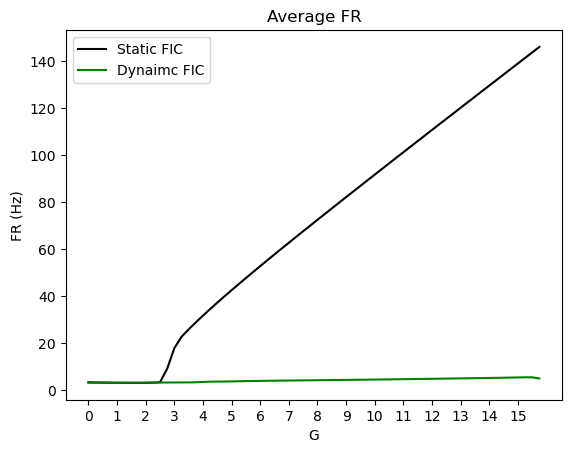

In [55]:
fig, ax = plt.subplots()
ax.plot(np.mean(all_rates, axis=2)[0], color='k', label='Static FIC')
ax.plot(np.mean(all_rates, axis=2)[1], color='g', label='Dynaimc FIC')

# Set x-axis tick labels from G_range
G_range = np.arange(0,16,0.25)
xtick_positions = range(0, len(G_range), 4)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([int(G_range[i]) for i in xtick_positions])

plt.title("Average FR")
plt.xlabel("G")
plt.ylabel("FR (Hz)")
plt.legend()


# Empirical fitting

In [3]:
data = np.squeeze(np.array(mat73.loadmat("data/BOLD_timeseries_HCP.mat")['BOLD_timeseries_HCP']))

In [2]:
data_struct = loadmat('./data/ts_coma24_AAL_symm_withSC.mat')

In [12]:
data = np.zeros((13,90,192))

In [18]:
data_struct['timeseries_CNT24_symm'][0][0].shape

(90, 192)

In [19]:
for i in range(13):
    data[i,:,:] = data_struct['timeseries_CNT24_symm'][0][i][:,:192]


In [20]:
#C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity']
C = data_struct['SC']

In [37]:


C = 0.2*C/np.max(C)
burnout = 5
coeffs = loadmat('./Results/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]

params = dmf.default_params(C=C)
params['seed'] = 1
params['G'] = 2.1
params['obj_rate'] = 3.44
LR = 200
DECAY = np.exp(a+np.log(LR)*b)
params['taoj'] = DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params['TR'] = 2.4
nb_steps = int((data.shape[-1]-2*burnout)*params['TR']/params['dtt'])
T = len(bold.T)
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')

In [28]:
sim_fcds = np.zeros((13,4005,4005))
sim_fcs = np.zeros((13,90,90))

In [38]:
for i in range(13):
    N = C.shape[0]
    with_decay = True
    with_plasticity = True
    rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True, with_plasticity=with_plasticity, with_decay=with_decay)

    bold[:, (np.ceil(burnout / params['TR'])).astype(int):]
    rates = rates[:, np.ceil(burnout * 1000).astype(int):]
    rates_inh = rates_inh[:, np.ceil(burnout * 1000).astype(int):]
    fic_t = fic_t[:, np.ceil(burnout * 1000).astype(int):]
    rates_fc = np.corrcoef(rates)
    rates_inh_fc = np.corrcoef(rates_inh)
    filt_bold = lfilter(b,a,bold)
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
    # Replace 'compute_fcd' with the appropriate function or code that computes time_fc
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc)
    mean_fic_dist = np.zeros(N)
    for n in range(N):
        reg_fic = fic_t[:, n]
        mean_fic_dist[n] = np.mean(reg_fic)
    sim_fcds[i] = fcd
    sim_fcs[i] = bold_fc

    

Calling run
Calling run
Calling run
Calling run
Calling run
Calling run
Calling run
Calling run
Calling run
Calling run
Calling run
Calling run
Calling run


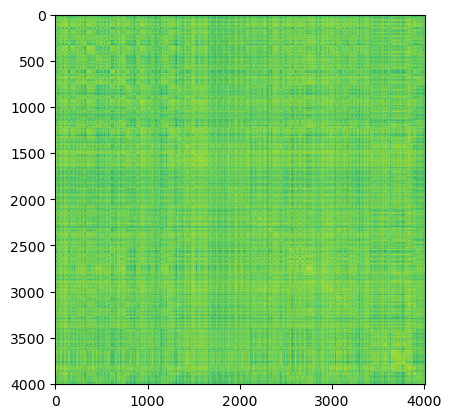

In [34]:

plt.imshow(np.mean(sim_fcds,axis=0))

In [35]:
emp_fcds = np.zeros((13,4005,4005))
emp_fcs = np.zeros((13,90,90))
for i in range(13):
    bold = data[i]
    bold[:, (np.ceil(burnout / params['TR'])).astype(int):]    
    filt_bold = lfilter(b,a,bold)
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
    # Replace 'compute_fcd' with the appropriate function or code that computes time_fc
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc)
    mean_fic_dist = np.zeros(N)
    for n in range(N):
        reg_fic = fic_t[:, n]
        mean_fic_dist[n] = np.mean(reg_fic)
    emp_fcds[i] = fcd
    emp_fcs[i] = bold_fc

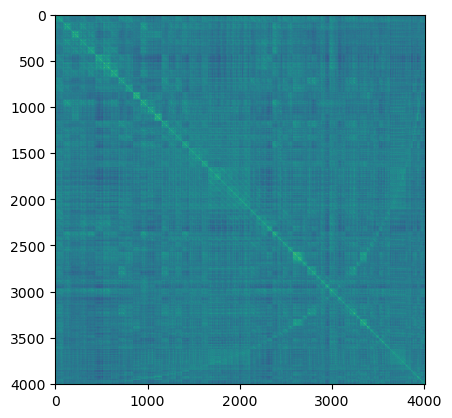

In [36]:
plt.imshow(np.mean(emp_fcds,axis=0))

In [43]:
from scipy.stats import ks_2samp
ks, p = ks_2samp(np.mean(emp_fcds,axis=0).flatten(),np.mean(emp_fcds,axis=0).flatten())

In [44]:
ks

0.0

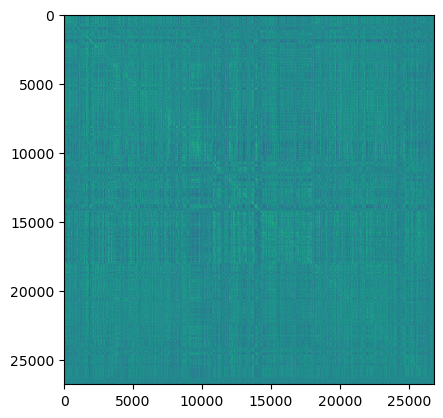

In [30]:
filt_empirical_bold = lfilter(b,a,data[0,:,400:-400])
time_fc = compute_fcd(filt_empirical_bold.T, wsize, overlap, isubfcd)
fcd = np.corrcoef(time_fc)
plt.imshow(fcd)

    Using multitaper spectrum estimation with 30 DPSS windows


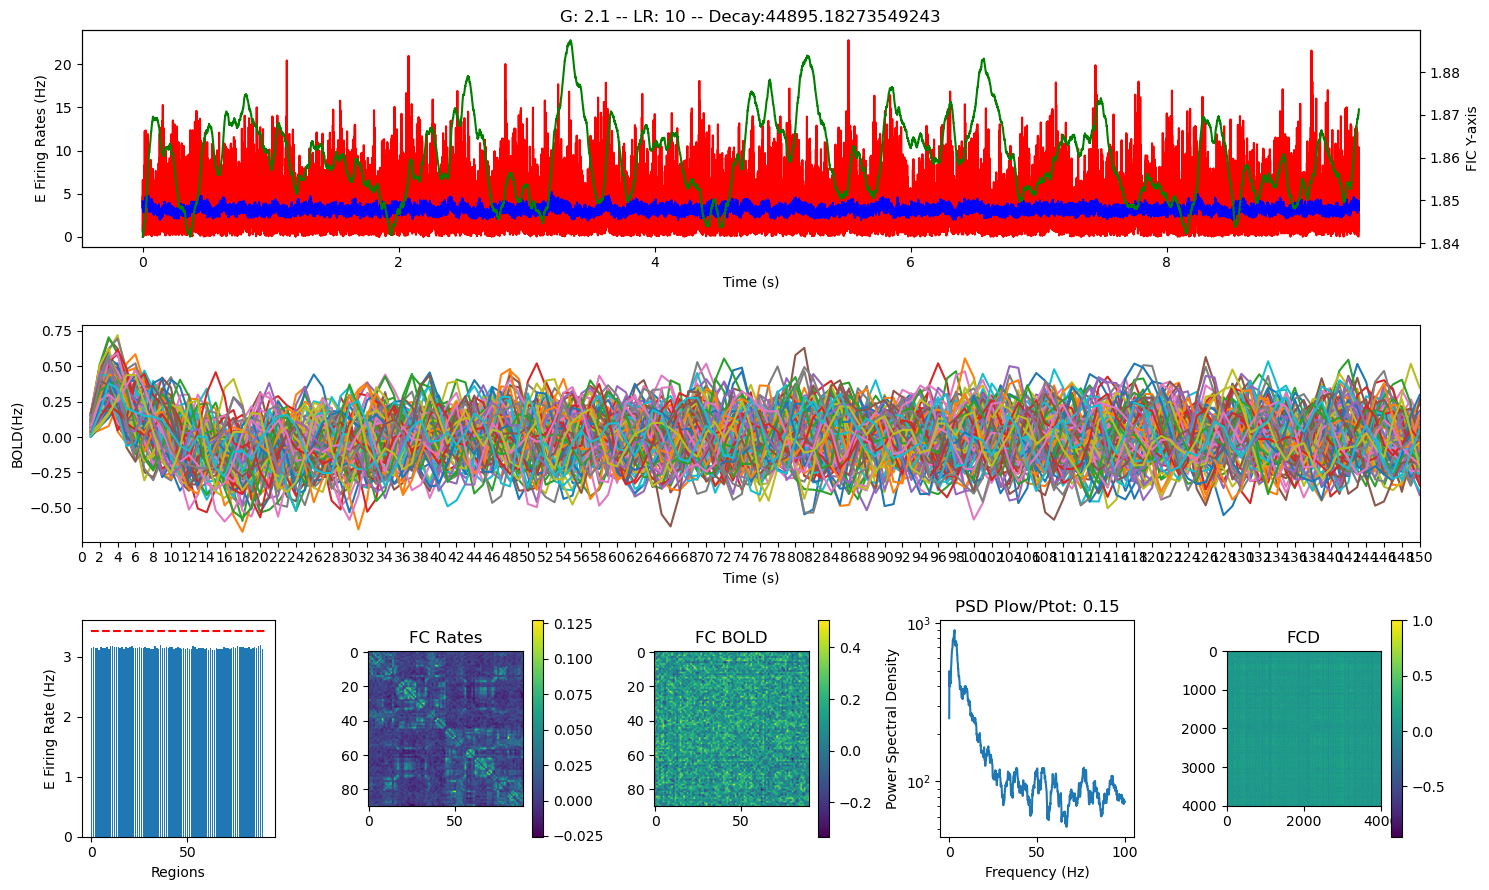

In [36]:
from mne.time_frequency import psd_array_multitaper
fig = plt.figure(figsize=(15, 9))
plt.axis('off')
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj'] if with_plasticity else 'No plasticity '} -- Decay:{params['taoj'] if with_decay else 'No decay'}")

#sel_t = np.arange(9000, 19000) #np.arange(1,rates.shape[1] +1 ) 
sel_t = np.arange(1,rates.shape[1] +1 ) 
sel_t_bold = np.arange(1, bold.shape[1] + 1)

# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
one_idx_freq = np.where(frequencies >= 1)[0][0]
plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)  

four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
one_idx_freq = np.where(frequencies >= 1)[0][0]
plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)                                        
slowest_reg = np.argmax(plow_ptot)


plt.subplot(3, 1, 1)
plt.plot(sel_t / 10000, rates[slowest_reg,sel_t-1], 'r')
plt.plot(sel_t / 10000, np.mean(rates[:,sel_t-1], axis=0), 'b')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t / 10000, np.mean(fic_t[:,sel_t-1], axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


"""
plt.subplot(3, 1, 1)
plt.plot(sel_t / 10000, rates[slowest_reg,sel_t-1], 'r')
plt.plot(sel_t / 10000, np.mean(rates[:,sel_t-1], axis=0), 'b')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t / 10000, np.mean(fic_t[:,sel_t-1], axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')
"""

plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)

plt.semilogy(frequencies, power_spectrum[slowest_reg,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[slowest_reg, one_idx_freq:four_idx_freq])/np.sum(power_spectrum[slowest_reg,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()


In [51]:
fcs = np.load('./Results/fit_coma_cnt/fit_fc_grid-slurmtest.npy')

In [69]:
isubfcd = np.triu_indices(C.shape[1],1)

In [72]:
len(isubfcd[0])

4005

Text(0, 0.5, 'G')

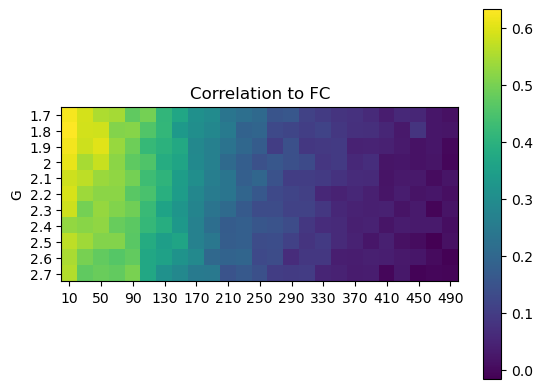

In [66]:
G_range = [1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7]#np.arange(0,G_max,G_step)
LR_range = np.arange(10,500,20)


fig, ax = plt.subplots()
pos = ax.imshow(fcs)


ytick_positions = range(0, len(G_range), 1)
ax.set_yticks(ytick_positions)
ax.set_yticklabels([G_range[i] for i in ytick_positions])

xtick_positions = range(0, len(LR_range), 2)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([int(LR_range[i]) for i in xtick_positions])


fig.colorbar(pos, ax=ax)
plt.title("Correlation to FC")
plt.ylabel("G")




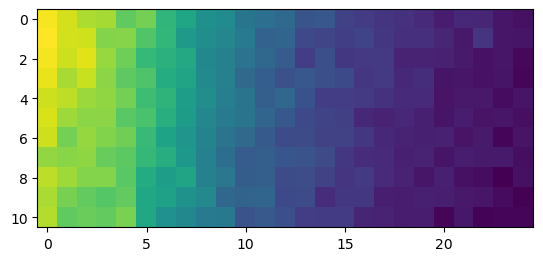

In [53]:
plt.imshow(fcs)